The data itself is too big, so we just train a partial of the training data, even for Google Colab Pro

In [1]:
#Run this if you don't have transformers
#!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel,BertForSequenceClassification,AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [3]:
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stop=stopwords.words('english') 
# def remove_stop_words(x):
#     for word in stop:
#         token = " " + word + " "
#         if (x.find(token) != -1):
#             x = x.replace(token, " ")
#     return x

In [4]:
train_data=pd.read_csv("/content/drive/Shareddrives/CS 247 project/data/train.csv")
#test_data=pd.read_csv("/content/drive/Shareddrives/CS 247 project/data/test.csv")


In [5]:
# Becuase it is too large so need to only use first 300000 data to act as the file to be splited
train_data=train_data[:300000]

In [6]:
train_data['question_text']=train_data['question_text'].str.lower()
sentences=train_data.question_text.values
# sentences=list(map(remove_stop_words, sentences))
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_data.target.values


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [8]:
input_ids=[]
for i in range(len(tokenized_texts)):
  input_ids.append(tokenizer.convert_tokens_to_ids(tokenized_texts[i]))

In [9]:

MAX_LEN = 256
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [10]:
#Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [11]:
#do the train test split of 8:2
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=56, test_size=0.2)

In [12]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [13]:
## Define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device ='cpu'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:

batch_size = 16



train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
lr = 2e-5
max_grad_norm = 1.0
num_total_steps = 1000



optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False) 


In [16]:
torch.cuda.empty_cache()

In [17]:
total_step = len(train_dataloader)

# Store our loss and accuracy for plotting
train_loss_set = []


epochs = 2

for epoch in range(epochs):
  
  

    # Training
    model.train()

    # Tracking variables
    tr_loss = 0

    # Train the data for one epoch
    for i, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss = outputs[0]
      train_loss_set.append(loss.item())    
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()
      optimizer.zero_grad()
      if (i) % 50 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))
        

Epoch [1/2], Step [1/15000], Loss: 0.9357
Epoch [1/2], Step [51/15000], Loss: 0.1492
Epoch [1/2], Step [101/15000], Loss: 0.2914
Epoch [1/2], Step [151/15000], Loss: 0.2592
Epoch [1/2], Step [201/15000], Loss: 0.0631
Epoch [1/2], Step [251/15000], Loss: 0.2439
Epoch [1/2], Step [301/15000], Loss: 0.0302
Epoch [1/2], Step [351/15000], Loss: 0.0136
Epoch [1/2], Step [401/15000], Loss: 0.0132
Epoch [1/2], Step [451/15000], Loss: 0.1586
Epoch [1/2], Step [501/15000], Loss: 0.3002
Epoch [1/2], Step [551/15000], Loss: 0.0342
Epoch [1/2], Step [601/15000], Loss: 0.0033
Epoch [1/2], Step [651/15000], Loss: 0.0661
Epoch [1/2], Step [701/15000], Loss: 0.0085
Epoch [1/2], Step [751/15000], Loss: 0.0100
Epoch [1/2], Step [801/15000], Loss: 0.1253
Epoch [1/2], Step [851/15000], Loss: 0.0458
Epoch [1/2], Step [901/15000], Loss: 0.0035
Epoch [1/2], Step [951/15000], Loss: 0.3221
Epoch [1/2], Step [1001/15000], Loss: 0.0364
Epoch [1/2], Step [1051/15000], Loss: 0.3188
Epoch [1/2], Step [1101/15000], L

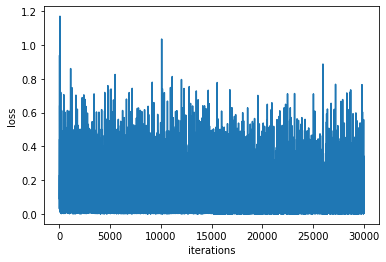

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_loss_set)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

In [19]:
from sklearn.metrics import f1_score

In [20]:
total_labels=[]
total_predictions=[]
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      # print (outputs)

      prediction = torch.argmax(outputs[0],dim=1)
      total_labels.append(b_labels)
      total_predictions.append(prediction)
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()

In [21]:
print('Test Accuracy of the model on val data is: {} %'.format(100 * correct / total))

Test Accuracy of the model on val data is: 94.70333333333333 %


In [22]:
len(total_labels)==len(total_predictions)

True

In [23]:
total_labels=[x.tolist() for x in total_labels]
total_predictions=[x.tolist() for x in total_predictions]

In [24]:
total_labels=list(np.concatenate(total_labels).flat)

In [25]:
total_predictions=list(np.concatenate(total_predictions).flat)

In [26]:
f1_score(total_labels, total_predictions)

0.6535862219315457

On a 300000 lines data, we have the result of 0.653. This is the result on the validation dataset